In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [11]:
import motion

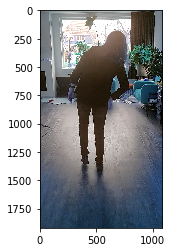

In [12]:
im = cv2.imread('coco/divera_trend.png')
plt.imshow(im)

In [13]:
mdl_pose_resnet = motion.pose_resnet.get_pose_model()

In [14]:
from motion.detect_human.fastai_utils import *
class OrientMdl(nn.Module):
    def __init__(self, pose_resnet, p=0.5):
        super(OrientMdl, self).__init__()
        self.cnn = nn.Sequential(*list(pose_resnet.children())[:2])
        self.pool = nn.Sequential(*[AdaptiveConcatPool2d(), Flatten()])
        self.head = nn.Sequential(*[nn.BatchNorm1d(128),nn.Dropout(p),nn.Linear(128, 4)])
        
    def forward(self,x):
        x = self.cnn(x)
        x = self.pool(x)
        x = self.head(x)
        return x
    
    def parameters_small(self):
        return [*list(self.pool.parameters()),*list(self.head.parameters())]

In [15]:
mdl = OrientMdl(mdl_pose_resnet)
mdl.eval()
print("")

In [16]:
import cv2
import pandas as pd
import imutils

from torch.utils.data import Dataset

from motion.detect_human_ssd import PredictionTransform


class RotationDataset(Dataset):
    def __init__(self, csv_file, type="train"):
        super(RotationDataset).__init__()
        self.df = pd.read_csv(csv_file)
        print("Dataset has {} samples.".format((self.df.shape[0])))
        self.trans = PredictionTransform(300)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self,index):
        data = dict(self.df.iloc[index, :])
        angle_i = np.random.randint(3)
        angle = [0,90,180,270][angle_i]
        img = cv2.imread(data["filename"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = imutils.rotate_bound(img,angle)
        return {"data":self.trans(img).float(), "target":angle_i}
    
rot_dl = DataLoader(RotationDataset("coco/val2017_one_human_train.csv"))
rot_val_dl = DataLoader(RotationDataset("coco/val2017_one_human_val.csv"))


Dataset has 925 samples.
Dataset has 225 samples.


In [56]:

from neural_pipeline.builtin.monitors.tensorboard import TensorboardMonitor
from neural_pipeline import (
    DataProducer,
    AbstractDataset,
    TrainConfig,
    TrainStage,
    ValidationStage,
    Trainer,
    FileStructManager,
)

# from ..detect_human import HumanBBox, BBoxDataset, IoU

fsm = FileStructManager(base_dir="models/detect_rotv_3/", is_continue=True)


train_dataset = DataProducer(
    [
       RotationDataset("coco/train2017_one_human.csv")
    ],
    batch_size=64,
    num_workers=5,
)
validation_dataset = DataProducer(
    [
        RotationDataset("coco/val2017_one_human_train.csv")
    ],
    batch_size=64,
    num_workers=2,
)

train_config = TrainConfig(
    [TrainStage(train_dataset), ValidationStage(validation_dataset)],
    # torch.nn.L1Loss(),
    nn.CrossEntropyLoss(),
    torch.optim.SGD(mdl.parameters_small(), lr=2e-2),
)

trainer = (
    Trainer(mdl, train_config, fsm, torch.device("cuda:0")).set_epoch_num(
        5
    )
    # .enable_lr_decaying(0.97, 1000)
)

trainer.monitor_hub.add_monitor(TensorboardMonitor(fsm, is_continue=True))
# trainer.monitor_hub.update_metrics({'accuracy':})
# .resume(from_best_checkpoint=False)
trainer.train()


Dataset has 27885 samples.
Dataset has 925 samples.


Epoch: [1]; train: [0.610226, 0.859208, 1.033706]; validation: [0.624086, 0.711271, 0.819416]


Epoch: [2]; train: [0.601630, 0.831962, 1.078225]; validation: [0.592312, 0.685460, 0.780460]


Epoch: [3]; train: [0.633606, 0.821085, 1.026177]; validation: [0.580758, 0.670089, 0.767451]


Epoch: [4]; train: [0.543727, 0.809458, 1.082050]; validation: [0.575706, 0.659867, 0.756977]


Epoch: [5]; train: [0.472189, 0.804680, 1.154770]; validation: [0.568938, 0.659496, 0.762230]


tensor([[0.5381, 0.2421, 0.1637, 0.0561]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


/home/tako/devtools/furry-geras/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


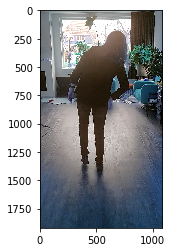

In [19]:
trans = PredictionTransform(300)
print(nn.Softmax()(  mdl(trans(im)[None,:].float().to(torch.device('cuda:0')))))
plt.imshow(im)

In [52]:
ds = RotationDataset("coco/val2017_one_human_train.csv")

Dataset has 925 samples.


1 1 [[0.04855  0.741366 0.204756 0.005328]]


/home/tako/devtools/furry-geras/env/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


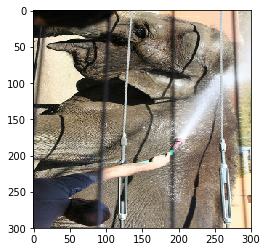

1 1 [[0.121918 0.553114 0.317981 0.006987]]


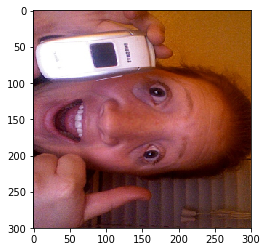

2 2 [[0.11523  0.337742 0.539171 0.007858]]


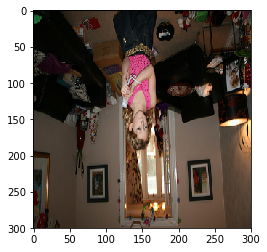

0 1 [[0.298819 0.426226 0.268352 0.006604]]


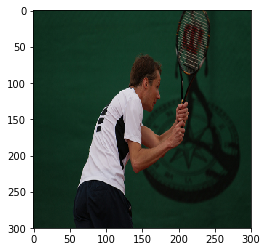

0 0 [[0.845667 0.121996 0.028886 0.003452]]


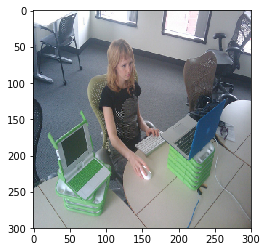

0 1 [[0.399294 0.409637 0.184211 0.006859]]


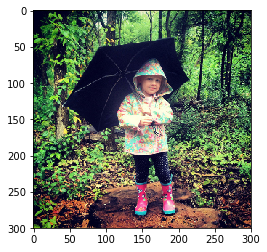

0 1 [[0.283706 0.563491 0.146888 0.005915]]


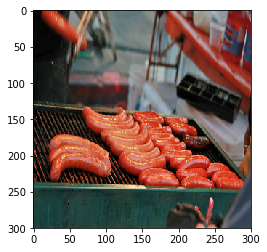

0 0 [[0.820367 0.106628 0.069094 0.003911]]


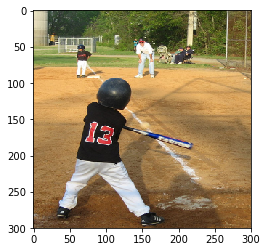

2 2 [[0.129599 0.287811 0.576598 0.005992]]


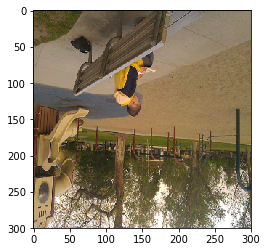

1 1 [[0.117154 0.699774 0.176065 0.007007]]


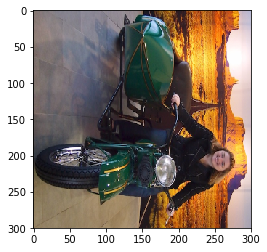

In [59]:

def plot_im(i,ds):
    sample = ds[i]
    im = sample['data']
    orignal = im.detach().numpy().transpose(1,2,0).astype(np.int)
    plt.imshow(orignal)
    pred = nn.Softmax()(  mdl(im[None,:].float().to(torch.device('cuda:0')))).cpu().detach().numpy()
    print(sample['target'],np.argmax(pred),pred)
    plt.show()

for i in range(10):
    plot_im(i,ds)

In [57]:
good = 0
for i in range(len(ds)) :
    sample = ds[i]
    im = sample['data']
    
    pred = np.argmax(nn.Softmax()(  mdl(im[None,:].float().to(torch.device('cuda:0')))).cpu().detach().numpy())
    good += int(pred == sample['target'])
print(good/len(ds))

/home/tako/devtools/furry-geras/env/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


0.7924324324324324


In [68]:
PATH = 'models/OrientMdl.pth'
torch.save(mdl.state_dict(), PATH)

In [ ]:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()